<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 23, 2021</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual Behavior Exercises Overview </h2>
    
<p> This notebook contains exercises covering several topics including behavior performance, single cell physiology and across session analysis.
  
<p> The exercises can be done in sequential order, or you can skip around to the exercises that interest you most. 
    
<p> If you get stuck, please ask a TA for help, look it up on stackoverflow, or check the solutions notebook. 
    We dont expect you to know everything already - the goal is to learn, and learning requires making mistakes and asking questions. 

<h3>Outline </h3>

<p><b>Behavior Exercises</b>
<ul><li>Exercise 1.1: Plot the distribution of reaction times for go trials from one session
    <li>Exercise 1.2: Plot reward rate over time during a session
<li>Exercise 1.3: Compute and plot hit rate over time during a session
<li>Exercise 1.4: Plot the average hit rate for each image. Dislay presented stimuli
<li>Exercise 1.5: Plot the correct response probability for all image transitions
</ul>
<p><b>Single Cell Physiology Exercises</b> - this section requires stimulus_response_df as well as other mindscope_utilities functions
<ul><li>Exercise 2.1: Plot activity across stimulus repetitions using the stimulus response dataframe
<li>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis. Binarize trials into running and stationary
<li>Exercise 2.3: Plot the trial averaged response across changes for one or all cells using the trial response dataframe. Examine pupil size effect on change responses
<li>Exercise 2.4: Create a heatmap of all cells' averaged responses following an image change. 


</ul>
<p><b>Across Session Physiology Exercises</b>
<ul><li>Exercise 3.1: Follow along to learn some useful pandas tricks for multi session data comparison
<li>Exercise 3.2: Compare the activity of matched cells across sessions
<li>Exercise 3.3: Merge all the experiments from a single container and plot the mean response for different image sets
<li>Exercise 3.4: Plot the trial averaged response for passive vs. active sessions from one container
</ul>
</div>

In [2]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible automatically
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

In [3]:
# Import allensdk modules for loading and interacting with the data
from allensdk.brain_observatory.behavior.behavior_project_cache \
import VisualBehaviorOphysProjectCache

In [4]:
# This cell will find the appropriate path to the data based on your platform.
# You may need to edit the strings in this cell based on your configuration.

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of the hard drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then linux (default here is for Ubuntu - insert your username; your distribution may differ)
    data_root = "/media/$USERNAME/Brain2019"
    
cache_path = os.path.join(data_root, 'dynamic-brain-workshop/visual_behavior/2021')

In [5]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)


C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\allensdk\api\cloud_cache\cloud_cache.py:272: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v0.3.0.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.0.1.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v0.3.0.json', 'visual-behavior-ophys_project_manifest_v1.0.1.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.0.1.json')
  warnings.warn(msg, OutdatedManifestWarning)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Pick an ophys experiment based on its <code>cre_line</code>, <code>imaging_depth</code>, <code>session_number</code> and with no <code>prior_exposure_to_session_type</code></b>
    
<p>1) Use <code>cache</code> to get ophys experiment table. Filter the experiments table according to your metadata of interest and get the <code>ophys_experiment_id</code> for a session of your choosing. 
    
<p>Hint: use pandas Boolean indexing to filter by multiple column values.
    
 __[Documentation for Boolean indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)__


In [8]:
# load the experiments dataframe
experiments_df = cache.get_ophys_experiment_table()
# print first 5 rows to familiarize yourself with it
experiments_df.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,...,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,...,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,...,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,...,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,...,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Subselect experiments based on your selection criteria, and assign them to a new variable called `selected_experiments`
</div>

In [10]:
selected_experiments = experiments_df[(experiments_df.cre_line == 'Vip-IRES-Cre') &
                                   (experiments_df.imaging_depth == 175) & 
                                   (experiments_df.session_number == 4) &
                                   (experiments_df.prior_exposures_to_session_type == 0)]


In [11]:
# print first few rows of your new selected_experiments df
selected_experiments.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,...,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
795953296,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,Vip-IRES-Cre,GCaMP6f,4.0,...,4,795625712,795742990,791352433,VisualBehavior,175,VISp,2018-12-14 20:17:05.000000,OPHYS_4_images_B,859887431
830093338,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,429952,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,138.0,Vip-IRES-Cre,GCaMP6f,4.0,...,6,829521794,829578829,825183217,VisualBehavior,175,VISp,2019-02-27 16:09:43.000000,OPHYS_4_images_B,859900570
968651977,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467953,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,183.0,Vip-IRES-Cre,GCaMP6f,4.0,...,3,967965969,968334595,957570596,VisualBehaviorTask1B,175,VISp,2019-10-16 15:28:20.000000,OPHYS_4_images_A,968807878
950833329,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,468866,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,155.0,Vip-IRES-Cre,GCaMP6f,4.0,...,10,949209988,950157787,929913236,VisualBehavior,175,VISp,2019-09-19 15:34:06.000000,OPHYS_4_images_B,951266634
1067647876,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,544261,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,135.0,Vip-IRES-Cre,GCaMP6f,4.0,...,4,1067604782,1067619789,1064333322,VisualBehavior,175,VISp,2020-12-02 22:33:29.000000,OPHYS_4_images_B,1067678625


In [14]:
print('There are {} experiments that met your criteria'.format(len(selected_experiments)))

There are 11 experiments that met your criteria


In [18]:
# Select one experiment id
experiment_id = selected_experiments.index.values[5]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Load the experiment object for your experiment, and asign it to <code>ophys_experiment</code> variable. <b>Hint:</b> You can use <code>get_behavior_ophys_experiment()</code> method that can be found in <code>cache</code>.

</div>

In [19]:
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

behavior_ophys_experiment_1067648397.nwb: 100%|████████████████████████████████████| 332M/332M [00:19<00:00, 17.2MMB/s]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

<p>This set of exercises explores precomputed behavior metrics, using the <code>trials</code> dataframe. The <code>trials</code> dataframe is organized around the times of stimulus identity changes (go trials) and sham change times (catch trials). It contains data and metadata for each behavioral trial, including lick times, reward times, and image identity. <p><b>Note:</b> the behavioral trials are not the same as stimulus presentations. One behavioral trial contains multiple stimulus presentations. 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
<p><b>Exercise 1.1: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) Get the <code>trials</code> dataframe from the <code>ophys_experiment</code> object. Remember to use <code>.copy()</code> method to avoid altering original dataframe.
  
</div>

In [20]:
# copy trials df and display last 
# few rows of the dataframe using .tail() method

trials_df = ophys_experiment.trials.copy()
trials_df.tail()

,start_time,stop_time,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,...,catch,auto_rewarded,correct_reject,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
760,3869.31557,3876.58844,[],NaN,0.0,False,False,True,True,False,...,False,False,False,7.27287,NaN,231640.0,3872.33954,inf,im000,im045
761,3876.82184,3884.84482,[],NaN,0.0,False,False,True,True,False,...,False,False,False,8.02298,NaN,232135.0,3880.59611,inf,im045,im073
762,3885.07865,3891.41690,"[3891.10019, 3891.46696]",NaN,0.0,False,False,False,False,True,...,False,False,False,6.33825,NaN,NaN,NaN,NaN,im073,im073
763,3891.83400,3903.61019,[3901.9756],NaN,0.0,False,False,True,True,False,...,False,False,False,11.77619,3901.9756,233260.0,3899.36155,2.61405,im073,im035
764,3903.84377,3912.61762,[],NaN,0.0,False,False,True,True,False,...,False,False,False,8.77385,NaN,233800.0,3908.36896,inf,im035,im000


In [21]:
# you can also use .keys() method to deplay all column names
trials_df.keys()

Index(['start_time', 'stop_time', 'lick_times', 'reward_time', 'reward_volume',
       'hit', 'false_alarm', 'miss', 'stimulus_change', 'aborted', 'go',
       'catch', 'auto_rewarded', 'correct_reject', 'trial_length',
       'response_time', 'change_frame', 'change_time', 'response_latency',
       'initial_image_name', 'change_image_name'],
      dtype='object')

`trials_df` contains many columns:
* `lick_times` -  if the animal licked during a trial, timestamps of licks in seconds
* `reward_time` - if the animal was rewarded during a trial, timestamps of reward in seconds
* `reward_volumn` - volume of water disposed if rewarded, in ml
* `hit` - if it was a hit trial, meaning a go trial that animal got correctly
* `false_alarm` - if it was a false alarm trial, meaning a no-go trial when animal licked
* `miss` - if it was a miss trial, a go trial but animal did not lick
* `stimulus_change` if the stimulus changed on this trial
* `aborted` - if the animal licked too quickly when the trials started, the trial was aborted
* `go` - if it was a go trials, True or False
* `catch` - if it was a catch trial, True or False (catch trial is a trial that would have been a go, but the image did not change
* `auto_rewarded` - if the trial was autorewarded; the first 5 go trials in the session are autorewarded to prime the animals for the task
* `correct_reject` - if the trial was a catch trial and the animal did not lick
* `start_time` - in seconds, start time of a trial
* `stop_time` -  in seconds, start time of a trial
* `trial_length` - in seconds, length of the trial
* `response_time` - in seconds, time of the animals response
* `change_frame` - 
* `change_time` - in seconds, time of a change image
* `response_latency` - in seconds, lick time post image change
* `initial_image_name` - identity of a repeated image in this trial
* `change_image_name` - identity of a change image in this trial


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
<p> 2) Filter the trials dataframe to get <code>go</code> trials only. 
</div>

In [22]:
# display values in response latency column for go trials
trials_df[trials_df['go']==True]['response_latency']

trials_id
114    0.51236
118    0.51245
126    0.54573
132    0.61254
134    0.52873
        ...   
758        inf
760        inf
761        inf
763    2.61405
764        inf
Name: response_latency, Length: 217, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Note:</b> <code>go</code> trials during which the animals did not respond have <code>inf</code> as a reponse latency value. This can be an inssue for plotting, because many functions expect finate values. We can replace <code>inf</code> with <code>NaN</code>.
</div>    

In [30]:
# replace 'inf' with 'NaN'
trials_df['response_latency'].replace(to_replace=np.inf, value=np.nan, inplace=True)

In [37]:
# make sure that there are no inf in the column anymore
# you can use .isin([np.inf]), which will give you bool output and .value_counts() to see how many True and False are there
trials_df[trials_df['go']==True]['response_latency'].isin([np.inf]).value_counts()

False    217
Name: response_latency, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is defined as the first lick time, in seconds, relative to the change time. 
</div>

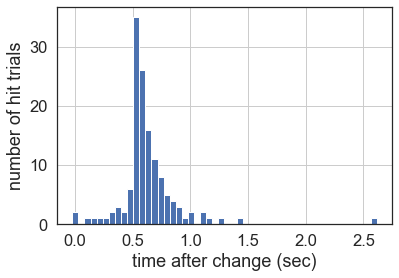

In [39]:
# plot histogram of response latencies
plt.hist(trials_df[trials_df['go']==True].response_latency.values, bins=50);
plt.ylabel('number of hit trials')
plt.xlabel('time after change (sec)')
plt.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Plot reward volumn over time during a session</b>

<p> 1) Use <code>calculate_reward_rate</code> function in <code>allensdk.brain_observatory.behavior.trial_processing</code> module to create a column <code>reward_rate</code> and <code>change_time</code> columns of the trials dataframe to plot reward rate over time. Remember to use <code>help(function_name)</code> to learn about how to use it.

<p> Was the mouse actively performing the task and earning rewards during the entire session? 
    
</div>

In [42]:
from allensdk.brain_observatory.behavior.trials_processing import calculate_reward_rate

In [43]:
trials_df['reward_rate'] = calculate_reward_rate(trials_df['response_latency'].values, 
                                              trials_df['start_time'], window = 1.5)

In [45]:
# remove behavioral trials that were aborted due to animal's premature licking
trials_df_sel = trials_df[trials_df['aborted']==False]

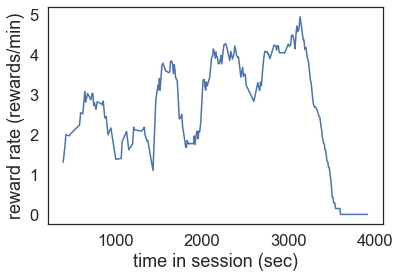

In [46]:
plt.plot(trials_df_sel['change_time'], trials_df_sel['reward_rate'])
plt.xlabel('time in session (sec)');
plt.ylabel('reward rate (rewards/min)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: Compute and plot hit rate over time during a session</b>

<p> 1) Filter the trials dataframe to get the <code>hit</code> column for <code>go</code> trials only. Assign this to a new variable called <code>go_responses</code> for further analysis. <b>Note:</b> Make sure that you get <code>go_responses</code> as a pandas series, without calling <code>.values</code>, so that the next step will work properly. 
    
<p> The <code>hit</code> column of the trials dataframe contains <i>True</i> for all trials where there was a licking response within the 750ms reward window and <i>False</i> where there was not. 
       
</div>

In [21]:
# use .value_counts() compute total number of hits (True) and misses (False) in the go trials
trials_df[trials_df['go']==True]['hit'].value_counts()

False    119
True      95
Name: hit, dtype: int64

It's not uncommon for sessions to have more misses than hits. Not all mice do the task well during multiple days. It's also very common for mice to do the task well at the beginning of a session but not towards the end of a session. This trend is likely related to lack of motivation after receiving sufficient reward.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Apply the pandas <code>rolling()</code> method to <code>go_responses</code> followed by <code>.mean()</code> to take a rolling mean across go trials. Set <code>window = 25, center = True</code> in the call to <code>rolling()</code> for a centered window over 25 trials. Set the output of this step to a variable called <code>rolling_hit_rate</code>. 

 __[Documentation for pandas.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)__
</div>

In [47]:
go_responses = trials_df[trials_df['go']==True]['hit']
rolling_hit_rate = go_responses.rolling(window=25, center=True).mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Plot the <code>rolling_hit_rate</code>. Label your axes.
       
</div>

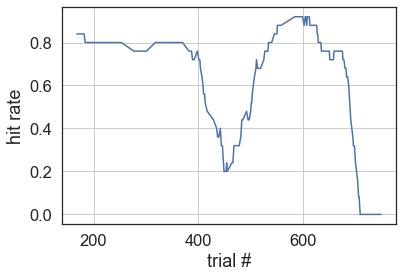

In [49]:
plt.plot(rolling_hit_rate)
plt.xlabel('trial #')
plt.ylabel('hit rate')
plt.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4: Plot the average hit rate for each image. Dislay presented stimuli.</b>

<p>1) Loop through the 8 images in this session and quantify the fraction of go trials where there was a correct response for each image to get the mean hit rate across the session. <b>Hint:</b> Use <code>ophys_experiment.trials.change_image_name.unique()</code> to get the image names.
        
</div>

In [50]:
# get the hit rate for each image
hit_rates = []
images = trials_df['change_image_name'].unique()
for image in images:
    image_change_trials = trials_df[(trials_df['change_image_name'] == image) & 
                                 (trials_df['go'] == True)]
    hit_rates.append(np.sum(image_change_trials['hit'])/len(image_change_trials))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Plot the average hit rate for each image, with image names along the x-axis. 
    
<p> <b>Bonus:</b> Sort hit rate values in ascending order and apply the same sorting to the image names along the x-axis. Hint: Useful functions include np.sort() and np.argsort()
</div>

In [55]:
# sort the hit rates in ascending order and sort the image labels in the same order
hit_rates_sorted = np.sort(hit_rates)
sorted_order = np.argsort(hit_rates)
images_sorted = images[sorted_order]

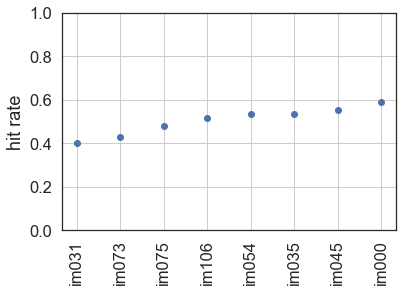

In [56]:
# plot hit rate by image with image names on the x-axis
fig, ax = plt.subplots()
plt.plot(hit_rates_sorted, 'o')
ax.set_xticks(np.arange(0,len(images_sorted),1));
ax.set_xticklabels(images_sorted, rotation=90);
ax.set_ylabel('hit rate');
ax.set_ylim(0,1);
ax.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Using <code>ophys_experiment.stimulus_template</code>, plot stimuli that were presented during this session.
</div>

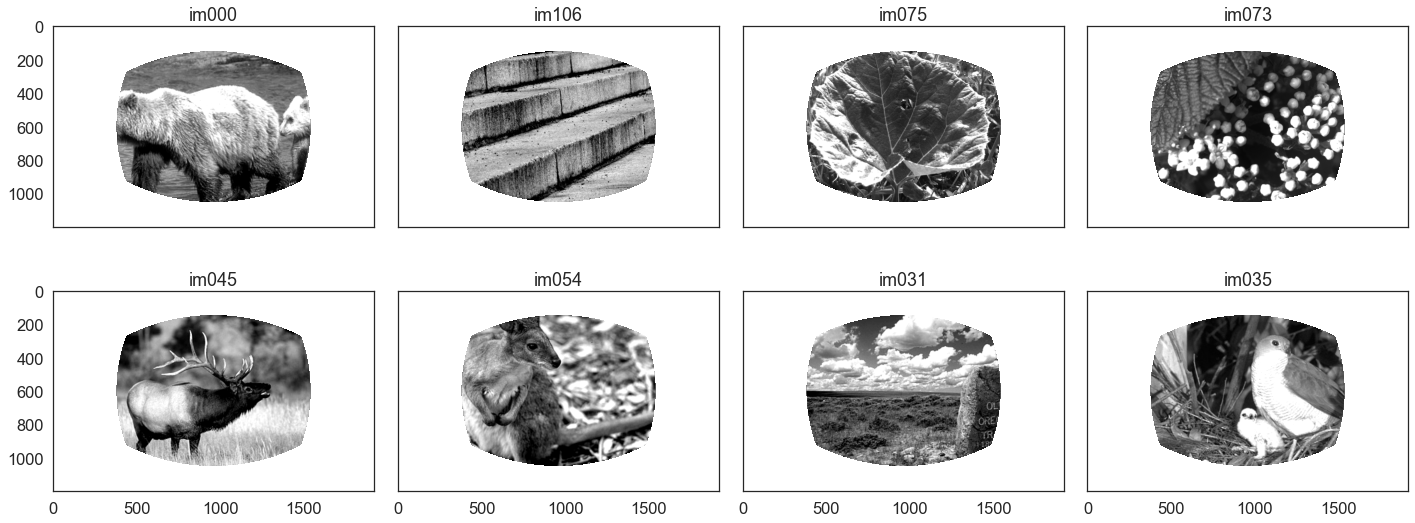

In [54]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(ophys_experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(ophys_experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Plot the correct response probability for all image transitions</b>

<p> The task cycles through 8 different images, resulting in 64 possible image transitions. Some image transitions might be easier for the mouse to detect than others. 

<p> 1) Use pandas <code>pivot_table()</code> on the trials table to count and average the <code>hit</code> values by <code>initial_image_name</code> as indices and <code>change_image_name</code> as columns. This will create a matrix of corrent response probability for all image transitions. 
    
 __[Documentation for pandas.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)__ 
 
</div>

In [58]:
# use pivot table to make a matrix of respones probability
response_matrix = pd.pivot_table(trials_df,  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')
response_matrix

change_image_name,im000,im031,im035,im045,im054,im073,im075,im106
initial_image_name,,,,,,,,
im000,0.000000,0.666667,0.50,0.25,0.75,0.25,0.50,0.50
im031,0.666667,0.000000,0.50,0.50,0.50,0.75,0.50,0.25
im035,0.750000,0.500000,0.00,0.50,0.75,0.50,0.50,0.75
im045,0.500000,0.250000,0.50,0.00,0.25,0.25,0.50,0.50
im054,0.750000,0.250000,0.75,0.75,0.00,0.25,0.25,0.50
im073,0.500000,0.250000,0.75,0.75,0.25,0.00,0.75,0.25
im075,0.750000,0.250000,0.50,0.50,0.75,0.50,0.00,0.75
im106,0.250000,0.500000,0.25,0.50,0.50,0.50,0.25,0.00


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Plot the hit transition matrix as a heatmap. Try using seaborn's heatmap function.

 __[Documentation for seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)__ 
    

<p> Did the mouse respond similarly for image changes compared to the same image repeated on catch trials? Are some image transitions more detectable than others? 

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

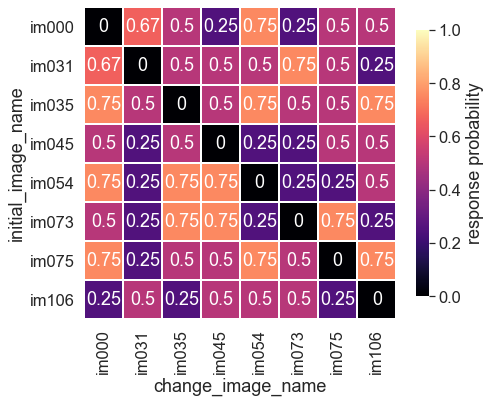

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01, cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Bonus:</b> Plot response probability across image transitions for engaged trials only


<p> Filter out trials where the mouse wasn't reliably performing the task using the value of the <code>reward_rate</code> column, with a threshold of 2 rewards per minute to distinguish engaged from disengaged periods, then plot the transition heatmap again. 

<p> Does varying engagement influence how we should analyze neural activity?

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

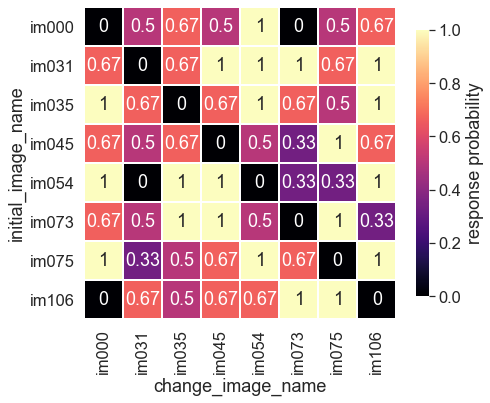

In [60]:
response_matrix = pd.pivot_table(trials_df[trials_df['reward_rate']>2],  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01,
            cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>
    
<p> These exercises explore neural activity aligned to stimulus trials. They make use of the <code>get_stimulus_response_df()</code> function and <code>stimulus_presentations</code> dataframe, as well as additional help functions in mindscope utilities that can add additional columns to stimulus_presentations_df with information about licks, rewards, mean pupil area or running speed. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;"
<p><b>Info about stimulus_presentations and stimulus_response dataframes</b>
    
<p> The <code>stimulus_presentations_df</code> contains metadata about each stimulus presentation in a given session. Additional steps are needed to add information about trials and animal behavior.
    
<p> The <code>stimulus_response_df</code> contains the response of each cell to each individual stimulus presentation during the session. 
    
<p> Both dataframes have a column called <code>trace</code> that contains a segment of each cell's fluorescence trace over a window of time. The duration of the window over which the <code>trace</code> was extracted can be specified in <code>get_stimulus_response</code> using <code>time_window</code> input variable. 
    
<p> If <code>compute_means</code> is True (default) in <code>get_stimulus_response</code>, you will have a column <code>mean_response</code> in the dataframe that contains each cell's response averaged over [0 time_window[1]] and <code>baseline_response</code> with pre stimulus activity mean.

</div>

In [31]:
import mindscope_utilities.visual_behavior_ophys as ophys
%load_ext autoreload
%autoreload 2

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.1: Plot activity across stimulus repetitions using the stimulus response dataframe and stimulus_presentations</b>

<p> 1) Assign the output of <code>ophys.get_stimulus_response_df()</code> for image changes only to a variable called <code>stimulus_response_df</code>. Make sure to check out documentation for this function to learn how to use it. You can call <code>help(function_name)</code> or <code>function_name()?</code> to print documentation. 

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Examine the <code>ophys.get_stimulus_response_df</code> to get a better understanding of the input variables. 

</div>

In [32]:
ophys.get_stimulus_response_df?

In [33]:
# get stimulus response dataframe, for 'dff' traces and only image changes
experiment_id = selected_experiments.index.values[0]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = [-1, 1.5],
                                                     data_type = 'dff',
                                                     event_type = 'changes')

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'behavior_monitoring', 'eye_tracking'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.29it/s]


In [34]:
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554
1,28,1086490441,"[1.2530322074890137, 1.1605233202650276, 1.232...","[-1.0, -0.9676781056230949, -0.935356211246189...",1.612638,1.314280
2,28,1086490480,"[-0.11520564556121826, -0.08244695689334353, 0...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.073871,-0.070798
3,28,1086490510,"[0.294612854719162, 0.42723664343041434, 0.426...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.993763,0.058067
4,28,1086490597,"[-0.06230897456407547, 0.02595783892605319, -0...","[-1.0, -0.9676781056230949, -0.935356211246189...",-0.008218,0.009103


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Assign ophys_experiment.stimulus_presentations to a variable called <code>stimulus_presentations_df</code>. Use .copy() to make a copy of the dataframe in order to avoid accidently editing the original.

</div>

In [35]:
# get stimulus_presentations_df
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()
stimulus_presentations_df.head()

,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
stimulus_presentations_id,,,,,,,,,,,
0,0.25021,18000.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17985,306.90981,307.16002
1,0.25018,18045.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18030,307.66042,307.91060
2,0.25022,18090.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18075,308.41101,308.66123
3,0.25012,18135.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18120,309.16175,309.41187
4,0.25024,18180.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18165,309.91222,310.16246


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Merge <code>stimulus_presentations_df</code> onto <code>stimulus_response_df</code> using <code>stimulus_presentations_id</code> column as a key.  Pick a cell and get all change trials for that cell by filtering your new <code>stimulus_response_df</code> by both the <code>cell_specimen_id</code> column and the <code>is_change</code> column.
</div>

In [36]:
# merge stimulus response df with stimulus presentations to a new df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, on='stimulus_presentations_id')

stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
1,28,1086490441,"[1.2530322074890137, 1.1605233202650276, 1.232...","[-1.0, -0.9676781056230949, -0.935356211246189...",1.612638,1.314280,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
2,28,1086490480,"[-0.11520564556121826, -0.08244695689334353, 0...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.073871,-0.070798,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
3,28,1086490510,"[0.294612854719162, 0.42723664343041434, 0.426...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.993763,0.058067,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772
4,28,1086490597,"[-0.06230897456407547, 0.02595783892605319, -0...","[-1.0, -0.9676781056230949, -0.935356211246189...",-0.008218,0.009103,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.1772


In [37]:
# get change stimulus trials for one cell only
cell_specimen_ids = stimulus_response_df.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[0]

stimulus_response_df_sel = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time
0,28,1086490397,"[-0.10610490292310715, -0.024462345094067597, ...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.097327,-0.020554,0.25026,19260.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,28,True,False,19245,327.92694,328.17720
33,41,1086490397,"[0.6293858885765076, 0.45818522909995896, 0.58...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.346553,0.537860,0.25020,19845.0,5,im054,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,41,True,False,19830,337.68490,337.93510
66,51,1086490397,"[0.19601398706436157, 0.2025626609180043, 0.27...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.162377,0.206973,0.25018,20295.0,3,im073,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,51,True,False,20280,345.19102,345.44120
99,68,1086490397,"[0.37653717398643494, 0.3406723946202891, 0.39...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.255973,0.227097,0.25021,21060.0,7,im035,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,68,True,False,21045,357.95142,358.20163
132,85,1086490397,"[0.6566617488861084, 0.8565127050266041, 0.620...","[-1.0, -0.9676781056230949, -0.935356211246189...",0.415265,0.822006,0.25020,21825.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,85,True,False,21810,370.71183,370.96203


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> Get the values of the <code>trace</code> column from your selected dataframe. Loop through these values and plot the traces for all change trials. Set color='gray. 
    
<b>Bonus:</b> Plot with time relative to the stimulus onset, in seconds, on the x-axis. Hint: Use the <code>trace_timestamps</code> column to get time relative to stimulus onset for one stimulus presentation.
    
<p> 4) Take the mean of the <code>trace</code> values and plot the average response on the same figure as the individual trials, this time setting color='b'.

Does this cell have a reliable response to image changes? 

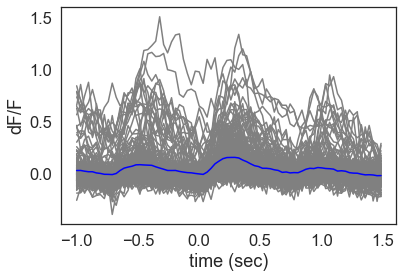

In [38]:
# plot for one cell
time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']

mean_trace = stimulus_response_df_sel['trace'].mean()

# loop through all trials and plot 
for trace in stimulus_response_df_sel['trace'].values: 
    plt.plot(time_seconds, trace, color='gray')
plt.xlabel('time (sec)')
plt.ylabel('dF/F')

# plot trace average
plt.plot(time_seconds, mean_trace, color='b');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   

<p> 5) Create this plot for multiple cells. How do different cells respond image changes?
    
<b>Bonus:</b> Plot multiple cells in one figure on different axes. Use <code>fig, ax = plt.subplots()</code> followed by <code>ax = ax.ravel()</code> to create iterable axes. 

 __[Documentation for matplotlib.pyplot.subplots()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html)__ 
    
 __[Why use fig, ax = plt.subplots() ? ](https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python )__ 

</div>

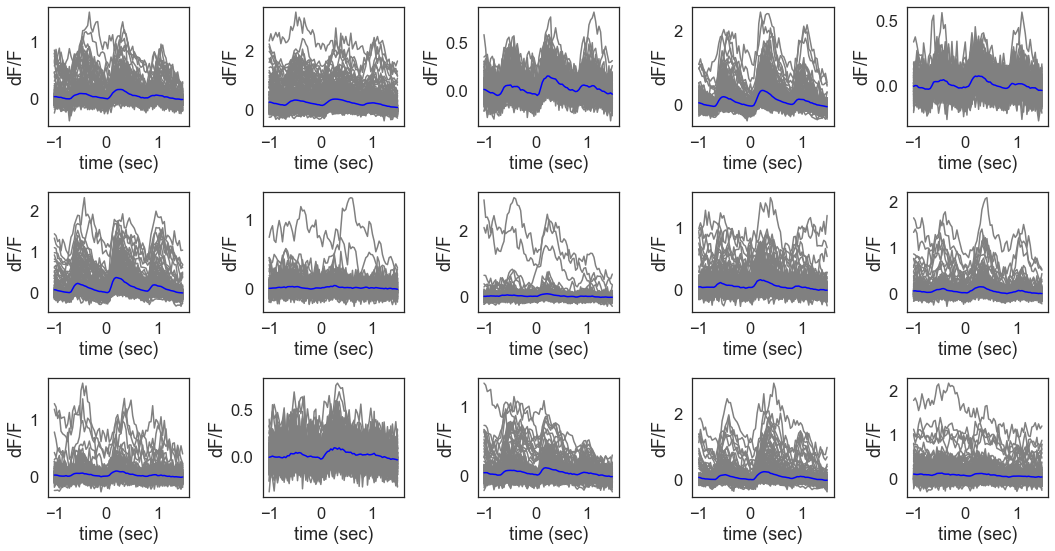

In [39]:
# plot for 15 cells
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.ravel()
if len(cell_specimen_ids) >=15:
    max_subplots = 15
else:
    max_subplots = len(cell_specimen_ids)
    
for i,cell_specimen_id in enumerate(cell_specimen_ids[:max_subplots]): 
    stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) &
                                             (stimulus_response_df['is_change']==True)] # this line is redundant if you set event_type='changes'
    time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']
    mean_trace = np.mean(stimulus_response_df_sel['trace'].values)
    
    for trace in stimulus_response_df_sel['trace'].values: 
        ax[i].plot(time_seconds, trace, color='gray')
    ax[i].set_xlabel('time (sec)')
    ax[i].set_ylabel('dF/F')
    
    ax[i].plot(time_seconds, mean_trace, color='b')
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis</b>

<p> Trial to trial variability could arise from differences in animal behavior. One possibility is modulation by running speed. 

<p> 1) Pick a cell and select all presentations of one image. 
    
<p> 2) Create a scatterplot of running speed vs neural response magnitude using the <code>mean_response</code> in <code>stimulus_response_df</code> and <code>mean_running_speed</code> columns that can be added to <code>stimulus_presentations</code> dataframe using <code>add_mean_running_speed_to_stimulus_presentations</code>. 

<p> The <code>mean_running_speed</code> is the average of the running_speed trace during the 250ms stimulus presentation for each image presentation. 
    
</div>

In [40]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[10]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')

# get stimulus_presentations
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()


C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:32<00:00,  2.50s/it]


In [41]:
# you can use the same time window to compute mean running speed as time window
# used for neural trace slicing. If you are not sure about what time widnow was used, you can use 
# trace timestamps to figure it out
time_window = [stimulus_response_df.loc[0]['trace_timestamps'].min(), 
               stimulus_response_df.loc[0]['trace_timestamps'].max()]

In [42]:
ophys.add_mean_running_speed_to_stimulus_presentations?

In [43]:
# add mean running speed
running_speed = ophys_experiment.running_speed.copy()
stimulus_presentations_df = ophys.add_mean_running_speed_to_stimulus_presentations(stimulus_presentations_df,
                                                                                  running_speed = running_speed,
                                                                                  time_window = time_window)

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\behavior\running_processing.py:365: UserWarning: Time array is 1 value shorter than encoder array. Last encoder value removed

  "value removed\n", UserWarning, stacklevel=1)


In [44]:
stimulus_presentations_df.head()

,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
stimulus_presentations_id,,,,,,,,,,,,
0,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
1,0.25022,18043.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18028,309.63700,309.88722,8.912504
2,0.25025,18088.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18073,310.38761,310.63786,8.402562
3,0.25013,18133.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18118,311.13829,311.38842,10.477524
4,0.25017,18178.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18163,311.88891,312.13908,11.584208


In [45]:
# merge stimulus_presentations with response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

In [46]:
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
0,0,1086611062,"[0.030847907066345215, -0.02070488084103799, -...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.019158,-0.021508,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
1,0,1086611186,"[-0.03996499255299568, -0.062121870007657454, ...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.179032,-0.085673,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
2,0,1086611465,"[0.04377448931336403, -0.011064421521214875, -...","[-1.0, -0.9676802421329982, -0.935360484265996...",-0.002371,-0.008695,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
3,0,1086611890,"[-0.11941056698560715, -0.18130022086672007, -...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.122943,-0.119670,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
4,0,1086612010,"[0.01778304949402809, 0.0013241037134142652, -...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.031848,-0.030976,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851


In [47]:
# get ids of cells in this experiment
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()


In [48]:
# select one cell
cell_specimen_id = cell_specimen_ids[4]

# select response of the cell to one image type
stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                         (stimulus_response_df['image_index']==0)]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,mean_running_speed
4,0,1086612010,"[0.01778304949402809, 0.0013241037134142652, -...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.031848,-0.030976,0.25021,17998.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17983,308.88642,309.13663,14.353851
17,1,1086612010,"[-0.07455243915319443, -0.010333739393912633, ...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.033972,0.044966,0.25022,18043.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18028,309.63700,309.88722,8.912504
30,2,1086612010,"[0.13337469100952148, 0.13108110564135295, 0.0...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.080773,0.005929,0.25025,18088.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18073,310.38761,310.63786,8.402562
43,3,1086612010,"[0.05434233695268631, 0.02174034405343296, -0....","[-1.0, -0.9676802421329982, -0.935360484265996...",0.080704,0.035658,0.25013,18133.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18118,311.13829,311.38842,10.477524
56,4,1086612010,"[0.14101997017860413, 0.24131818119681248, 0.1...","[-1.0, -0.9676802421329982, -0.935360484265996...",0.118784,0.082439,0.25017,18178.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4,False,False,18163,311.88891,312.13908,11.584208


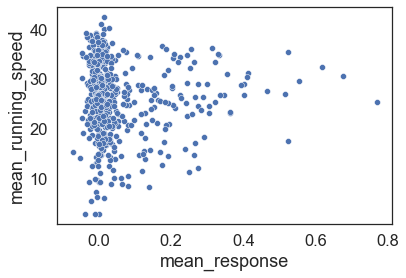

In [49]:
# plot scatter plot of mean response vs. running speed
fig, ax = plt.subplots()
ax = sns.scatterplot(data=stimulus_response_df_sel, x='mean_response', y='mean_running_speed', ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Compute the Pearson correlation between the image-trial-wise <code>mean_response</code> and <code>mean_running_speed</code> using <code>scipy.stats.pearsonr()</code>. Is there a correlation? 

</div>

In [50]:
# get pearson correlation 
import scipy.stats as st
r, p = st.pearsonr(stimulus_response_df_sel['mean_response'].values, stimulus_response_df_sel['mean_running_speed'].values)
print('r = ', np.round(r,3), 'p = ', np.round(p,3))

r =  -0.014 p =  0.742


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> <b>Bonus:</b> Compute the running correlation for all cells in the session and plot a histogram of the values. 

</div>

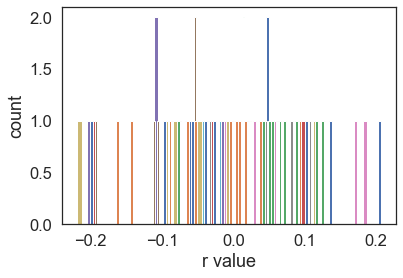

In [51]:
# get pearson correlation values for all cells
fig, ax = plt.subplots(1,1)
image_numbers = stimulus_response_df['image_index'].unique()
for cell_specimen_id in cell_specimen_ids:
    r_values = []
    for image_number in image_numbers:
        tmp = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                                 (stimulus_response_df['image_index']==image_number)]
        r, p = st.pearsonr(tmp['mean_response'].values, tmp['mean_running_speed'].values)
        r_values.append(r)
        
    ax.hist(r_values, bins=50);
    ax.set_xlabel('r value');
    ax.set_ylabel('count');
    
    

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) You can also binarize running speed into running and sitting trials. You can plot an average image response when the animals are running or sitting still. 
</div>


In [52]:
cell_specimen_id = cell_specimen_ids[6]

# select response of the cell to one image type
stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id)]

Text(0, 0.5, 'count')

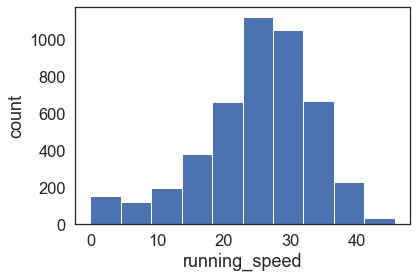

In [53]:
plt.hist(stimulus_response_df_sel['mean_running_speed'].values)
plt.xlabel('running_speed')
plt.ylabel('count')

In [54]:
# binarize
stimulus_response_df_sel.loc[stimulus_response_df_sel['mean_running_speed'] > 10,'running_binary'] = 'running'
stimulus_response_df_sel.loc[stimulus_response_df_sel['mean_running_speed'] <= 10,'running_binary'] = 'sitting'

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [55]:
stimulus_response_df_sel['running_binary'].value_counts()

running    4300
sitting     303
Name: running_binary, dtype: int64

<AxesSubplot:xlabel='image_index', ylabel='mean_response'>

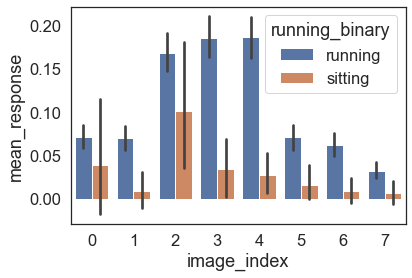

In [56]:
sns.barplot(data=stimulus_response_df_sel,
            x='image_index',
            y = 'mean_response',
            hue = 'running_binary')

Looks like although individual cells may not show strong correlation with running speed, population activity is modulated by animal's movements. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.3: Plot the trial averaged response across changes for one or all cells using the trial response dataframe. Examine pupil size effect on change responses.</b>
   
<p> 1) Using <code>get_stimulus_response_df</code> with stimuluse presentation to plot average responses to images that are non-changes and changes. Do images elicit a different response on the first presentation?

</div>

In [57]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[11]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')

# get stimulus_presentations
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:32<00:00,  2.49s/it]


In [58]:
#append stimulus presentaiton information to response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

<AxesSubplot:xlabel='image_name', ylabel='mean_response'>

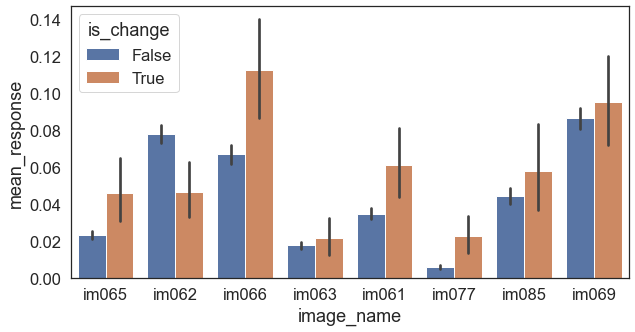

In [59]:
fig, ax = plt.subplots(1,1, figsize =(10,5))
sns.barplot(data = stimulus_response_df, 
             y ='mean_response',
             x = 'image_name',
             hue = 'is_change')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 2) Are there differences in mean pupil size on non-change vs change stimulus trials? Use <code>ophys.add_mean_pupil_area_to_stimulus_presentations</code> to add mean pupil area to the stimulus presentations dataframe

</div>

In [60]:
eye_tracking = ophys_experiment.eye_tracking
stimulus_presentations_df = ophys.add_mean_pupil_area_to_stimulus_presentations(stimulus_presentations_df, 
                                                                                eye_tracking,
                                                                                time_window = [0, 1.5])

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


In [62]:
#append stimulus presentaiton information to response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df[['mean_pupil_area']], 
                                                on='stimulus_presentations_id')

<AxesSubplot:xlabel='image_name', ylabel='mean_pupil_area'>

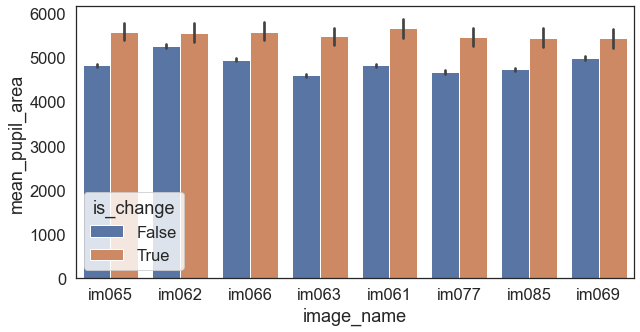

In [63]:
fig, ax = plt.subplots(1,1, figsize =(10,5))
sns.barplot(data = stimulus_response_df, 
             y ='mean_pupil_area',
             x = 'image_name',
             hue = 'is_change')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Plot the average <code>trace</code> across trials for one cell and each image name, with a shaded color indicating pupil size. Plot the x-axis in seconds relative to the <code>change_time</code>. 

In [73]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()
cell_specimen_id = cell_specimen_ids[2]

stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id)] 


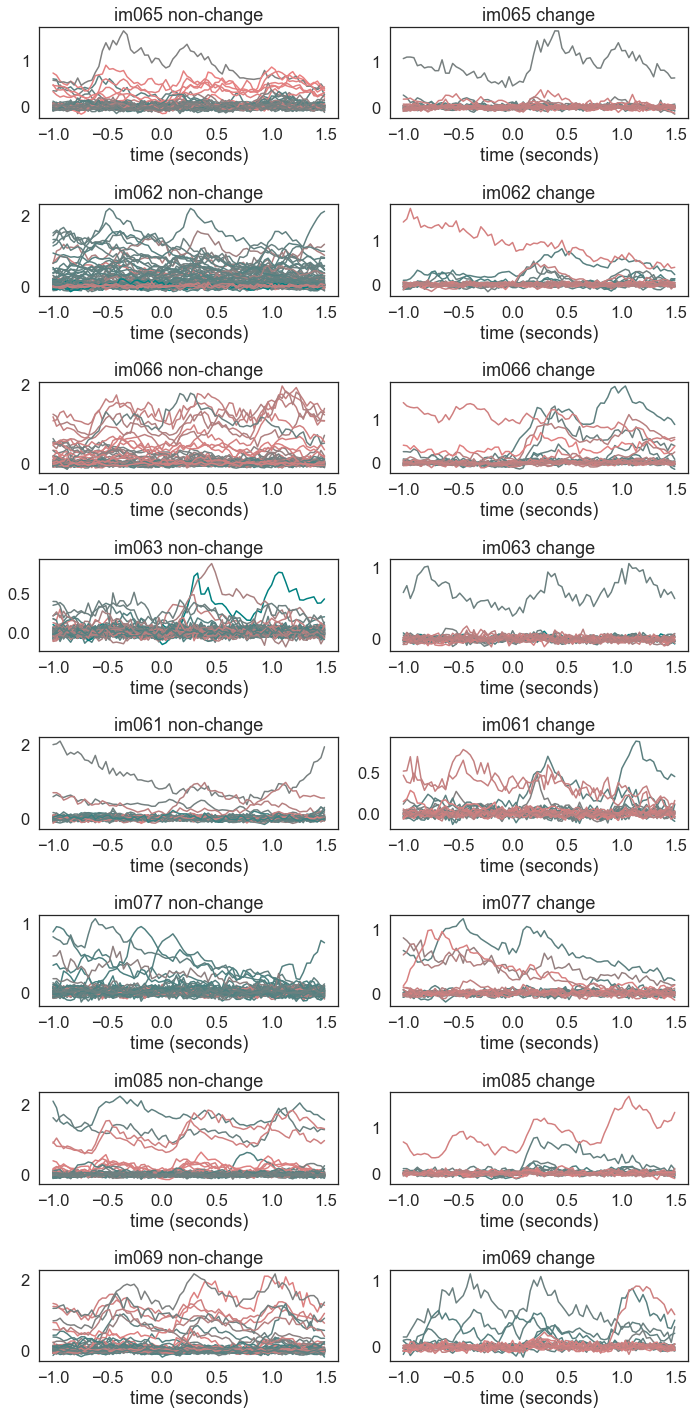

In [74]:

image_names = stimulus_response_df_sel['image_name'].unique()
fig, ax  = plt.subplots(len(image_names),2, figsize = (10,20))
timestamps = stimulus_response_df_sel.iloc[0]['trace_timestamps']
max_pupil_area = stimulus_response_df_sel['mean_pupil_area'].max()
for i,image_name in enumerate(image_names):
    tmp = stimulus_response_df_sel[(stimulus_response_df_sel['image_name']==image_name) &
                                  (stimulus_response_df_sel['is_change']==False)]
    all_trials = np.arange(0, tmp.shape[0])
    random_trials = np.random.choice(len(all_trials), size=100, replace=False)
    for t in random_trials:
        trace = tmp.iloc[t]['trace']
        pupil_area = tmp.iloc[t]['mean_pupil_area']
        ax[i,0].plot(timestamps, trace, color = [pupil_area/max_pupil_area, .5, .5])
    ax[i,0].set_title(image_name + ' non-change')
    ax[i,0].set_xlabel('time (seconds)')
    tmp = stimulus_response_df_sel[(stimulus_response_df_sel['image_name']==image_name) &
                                  (stimulus_response_df_sel['is_change']==True)]
    
    for t in range(0, tmp.shape[0]):
        trace = tmp.iloc[t]['trace']
        pupil_area = tmp.iloc[t]['mean_pupil_area']
        ax[i,1].plot(timestamps, trace, color = [pupil_area/max_pupil_area, .5, .5])
    ax[i,1].set_title(image_name + ' change')
    ax[i,1].set_xlabel('time (seconds)')
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
 
<p> 4) Loop through the 8 images shown in this session and plot the average response for each image when it changes for this cell as a function of reward rate. Hint: use <code>add_reward_rate_to_stimulus_presentations_df</code> to add reward date to <code>stimulus_presentations_df</code>, then merge it onto <code>stimulus_response_df</code>
    
Bonus: Make the same plots but instead of plotting absolute mean responses, plot mean responses that are relative to the baseline response. Use <code>baseline_response</code> as your reference point. 
    
</div>

In [75]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[11]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')


C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:32<00:00,  2.51s/it]


In [77]:
stimulus_presentations_df = ophys_experiment.stimulus_presentations.copy()
eye_tracking = ophys_experiment.eye_tracking
stimulus_presentations_df = ophys.add_mean_pupil_area_to_stimulus_presentations(stimulus_presentations_df, 
                                                                                eye_tracking,
                                                                                time_window = [0, 1.5])

In [78]:
trials_df = ophys_experiment.trials.copy()
stimulus_presentations_df = ophys.add_reward_rate_to_stimulus_presentations_df(trials_df, stimulus_presentations_df)

In [79]:
stimulus_response_df = stimulus_response_df.join(stimulus_presentations_df, 
                                                on='stimulus_presentations_id')

Text(0.5, 1.0, 'response to change')

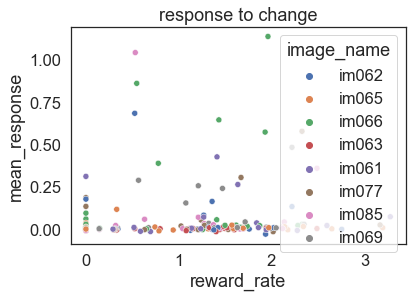

In [80]:
cell_specimen_id = cell_specimen_ids[2]

stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'mean_response',
                hue = 'image_name')
ax.set_title('response to change')

In [81]:
# make a new column with subtracted baseline response
stimulus_response_df['response_mean_rel'] = stimulus_response_df['mean_response'] - \
                                            stimulus_response_df['baseline_response']


Text(0.5, 1.0, 'response to change')

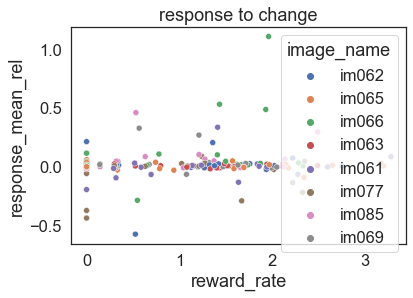

In [82]:
stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'response_mean_rel',
                hue = 'image_name')
ax.set_title('response to change')


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.4: Create a heatmap of all cells' trial averaged responses following an image change</b>

<p>From <code>stimulus_response_df</code>, use <code>mean()</code> method to take an average of response traces for each cell and add them to a new pandas dataframe with three columns: cell_specimen_id, mean_trace, trace_timestamps. Or create a response matrix of n_cells by n_timestamps.
       
<p>Sort responses using <code>np.argsort</code> before plotting to reveal any temporal structure in mean responses to changes
    
</div>

In [84]:
experiment_id = selected_experiments.index.values[9]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment,
                                                     event_type = 'changes')

C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
C:\Users\iryna.yavorska\AppData\Roaming\Python\Python37\site-packages\allensdk\brain_observatory\behavior\session_apis\data_transforms\behavior_ophys_data_transforms.py:189: UserWarning: Monitory delay calculation failed with ValueError
    "operands could not be broadcast together with shapes (4500,) (4501,) "
looking monitor delay up from table for rig: CAM2P.3 
delay: 0.

In [85]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()

mean_df = pd.DataFrame(columns = {'cell_specimen_id',
                                 'mean_trace',
                                 'trace_timestamps'})
timestamps = stimulus_response_df.iloc[0]['trace_timestamps']
for cell_specimen_id in cell_specimen_ids:
    tmp = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
    mean_df = mean_df.append({'cell_specimen_id': cell_specimen_id,
                    'mean_trace': tmp['trace'].mean(),
                    'trace_timestamps': timestamps},
                     ignore_index=True )

In [86]:
# create a response matrix
response_matrix = mean_df.mean_trace.values
response_matrix = np.stack(response_matrix, axis=0)
response_matrix.shape


(18, 186)

In [87]:
# sort cells in descending order
order = np.argsort(np.max(response_matrix,1))
response_matrix_sorted = response_matrix[order,:]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 4) Plot a heatmap of all cells' mean trace for their preferred image. Set the vmax of the heatmap equal to the 95% percentile value of the response array using <code>np.percentile()</code>. Set vmin to 0. 
    
 __[Documentation for numpy.percentile()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)__ 

<p> What structure do you see in this population? Bonus: Sort the cells to help see structure in the data.



</div>

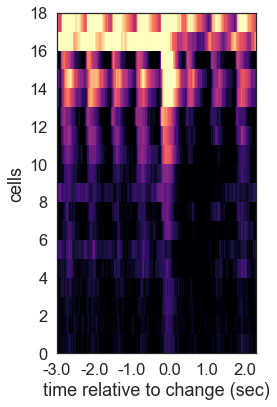

In [88]:


# create the plot
fig, ax = plt.subplots(figsize=(4,6))
ax.pcolormesh(response_matrix_sorted, cmap='magma', vmin=0, vmax=np.percentile(response_matrix, 95))
ax.set_ylabel('cells')

# set xticks and xticklabels
ax.set_xticks(np.arange(0, response_matrix.shape[1], 35))
ax.set_xticklabels(np.arange(timestamps[0], timestamps[-1]))
ax.set_xlabel('time relative to change (sec)');
fig.tight_layout()